In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

df = pd.read_csv("../data/processed/merged_country_year.csv")

df.head()

,country_x,iso3,year,NY.GDP.PCAP.CD,SP.DYN.LE00.IN,SP.URB.TOTL.IN.ZS,country_y,pm25
0,Afghanistan,AFG,2010.0,560.621505,60.702,23.737,Afghanistan,68.97
1,Afghanistan,AFG,2011.0,606.694676,61.250,23.948,Afghanistan,66.94
2,Afghanistan,AFG,2012.0,651.417134,61.735,24.160,Afghanistan,68.26
3,Afghanistan,AFG,2013.0,637.087099,62.188,24.373,Afghanistan,72.18
4,Afghanistan,AFG,2014.0,625.054942,62.260,24.587,Afghanistan,68.06


In [8]:
import pandas as pd

# Work on a copy
d = df.copy()

# Rename to readable names
d = d.rename(columns={
    "NY.GDP.PCAP.CD": "gdp_per_capita_usd",
    "SP.DYN.LE00.IN": "life_expectancy_yrs",
    "SP.URB.TOTL.IN.ZS": "urban_pop_pct"
})

# Fix dtypes
d["year"] = d["year"].astype("int64")
d["pm25"] = pd.to_numeric(d["pm25"], errors="coerce")

# Keep a single country column
d["country"] = d["country_x"].where(d["country_x"].notna(), d["country_y"])
d = d.drop(columns=["country_x", "country_y"])

# If any accidental duplicates by iso3-year, average them (rare but safe)
d = (
    d.groupby(["iso3", "country", "year"], as_index=False)
     .agg({
         "gdp_per_capita_usd": "mean",
         "life_expectancy_yrs": "mean",
         "urban_pop_pct": "mean",
         "pm25": "mean"
     })
     .sort_values(["iso3", "year"])
     .reset_index(drop=True)
)

# Quick integrity checks
print("Rows, Cols:", d.shape)
print("Duplicate iso3-year pairs:", d.duplicated(subset=["iso3", "year"]).sum())
print("Years span:", d["year"].min(), "→", d["year"].max())
print(d.isna().sum())  # see what's missing
d.head()


Rows, Cols: (1840, 7)
Duplicate iso3-year pairs: 0
Years span: 2010 → 2019
iso3                    0
country                 0
year                    0
gdp_per_capita_usd     22
life_expectancy_yrs     0
urban_pop_pct           0
pm25                    0
dtype: int64


,iso3,country,year,gdp_per_capita_usd,life_expectancy_yrs,urban_pop_pct,pm25
0,AFG,Afghanistan,2010,560.621505,60.702,23.737,68.97
1,AFG,Afghanistan,2011,606.694676,61.250,23.948,66.94
2,AFG,Afghanistan,2012,651.417134,61.735,24.160,68.26
3,AFG,Afghanistan,2013,637.087099,62.188,24.373,72.18
4,AFG,Afghanistan,2014,625.054942,62.260,24.587,68.06


iso3                    0
country                 0
year                    0
gdp_per_capita_usd     22
life_expectancy_yrs     0
urban_pop_pct           0
pm25                    0
dtype: int64


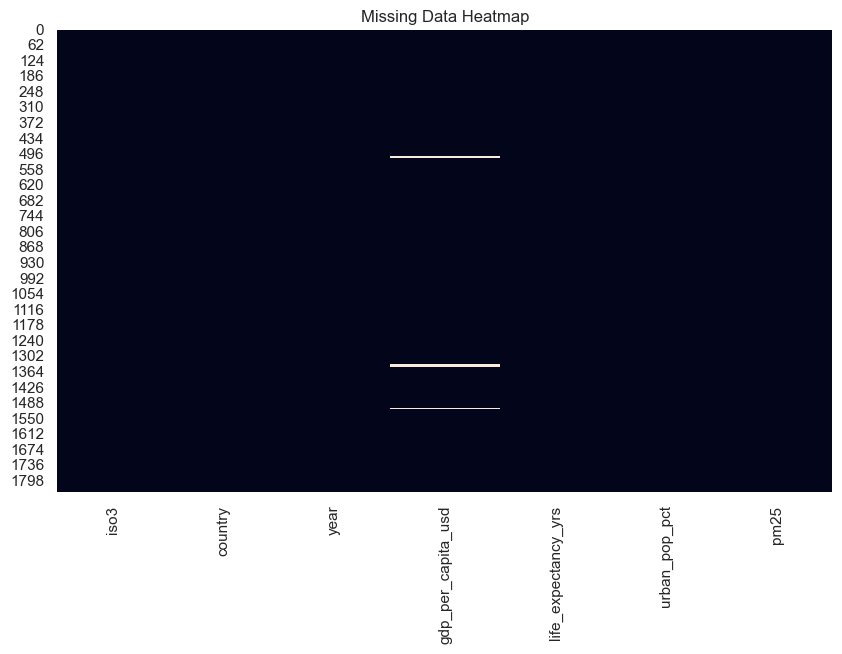

,count,mean,std,min,25%,50%,75%,max
year,1840.0,2014.500000,2.873062,2010.000000,2012.000000,2014.500000,2017.000000,2019.000000
gdp_per_capita_usd,1818.0,14824.332513,22965.753593,210.236495,1854.567753,5866.118087,16878.442695,195693.570739
life_expectancy_yrs,1840.0,71.196902,8.370429,31.530000,65.419750,72.275500,77.277957,86.151000
urban_pop_pct,1840.0,57.653976,22.841864,10.642000,39.116500,57.336000,76.786750,100.000000
pm25,1840.0,22.582307,14.336355,4.920000,11.440000,18.660000,29.750000,72.180000


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Missing values summary
print(d.isna().sum())

# Quick missingness heatmap
sns.heatmap(d.isna(), cbar=False)
plt.title("Missing Data Heatmap")
plt.show()

# Basic descriptive stats
d.describe().T


In [12]:
# Basic info
d.info()

# Summary stats
d.describe()

# Number of unique countries
d['country'].nunique(), d['iso3'].nunique()

# Years range
d['year'].min(), d['year'].max()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1840 entries, 0 to 1839
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   iso3                 1840 non-null   object 
 1   country              1840 non-null   object 
 2   year                 1840 non-null   int64  
 3   gdp_per_capita_usd   1818 non-null   float64
 4   life_expectancy_yrs  1840 non-null   float64
 5   urban_pop_pct        1840 non-null   float64
 6   pm25                 1840 non-null   float64
dtypes: float64(4), int64(1), object(2)
memory usage: 100.8+ KB


(2010, 2019)

In [13]:
import requests

# Load World Bank country metadata (includes region & income group)
meta_url = "http://api.worldbank.org/v2/country?format=json&per_page=500"
meta_data = requests.get(meta_url).json()[1]
meta_df = pd.DataFrame(meta_data)

# Keep relevant columns
meta_df = meta_df[["id", "name", "region", "incomeLevel"]].rename(columns={
    "id": "iso3",
    "name": "country_official",
    "region": "region_dict",
    "incomeLevel": "income_dict"
})

# Extract readable names from dicts
meta_df["region"] = meta_df["region_dict"].apply(lambda x: x["value"] if isinstance(x, dict) else None)
meta_df["income_group"] = meta_df["income_dict"].apply(lambda x: x["value"] if isinstance(x, dict) else None)

# Drop old dict columns
meta_df = meta_df.drop(columns=["region_dict", "income_dict"])

# Merge into our data
d = d.merge(meta_df, on="iso3", how="left")

# Quick check
d[["iso3", "country", "region", "income_group"]].drop_duplicates().head(10)


,iso3,country,region,income_group
0,AFG,Afghanistan,"Middle East, North Africa, Afghanistan & Pakistan",Low income
10,AGO,Angola,Sub-Saharan Africa,Lower middle income
20,ALB,Albania,Europe & Central Asia,Upper middle income
30,AND,Andorra,Europe & Central Asia,High income
40,ARE,United Arab Emirates,"Middle East, North Africa, Afghanistan & Pakistan",High income
50,ARG,Argentina,Latin America & Caribbean,Upper middle income
60,ARM,Armenia,Europe & Central Asia,Upper middle income
70,ATG,Antigua and Barbuda,Latin America & Caribbean,High income
80,AUS,Australia,East Asia & Pacific,High income
90,AUT,Austria,Europe & Central Asia,High income


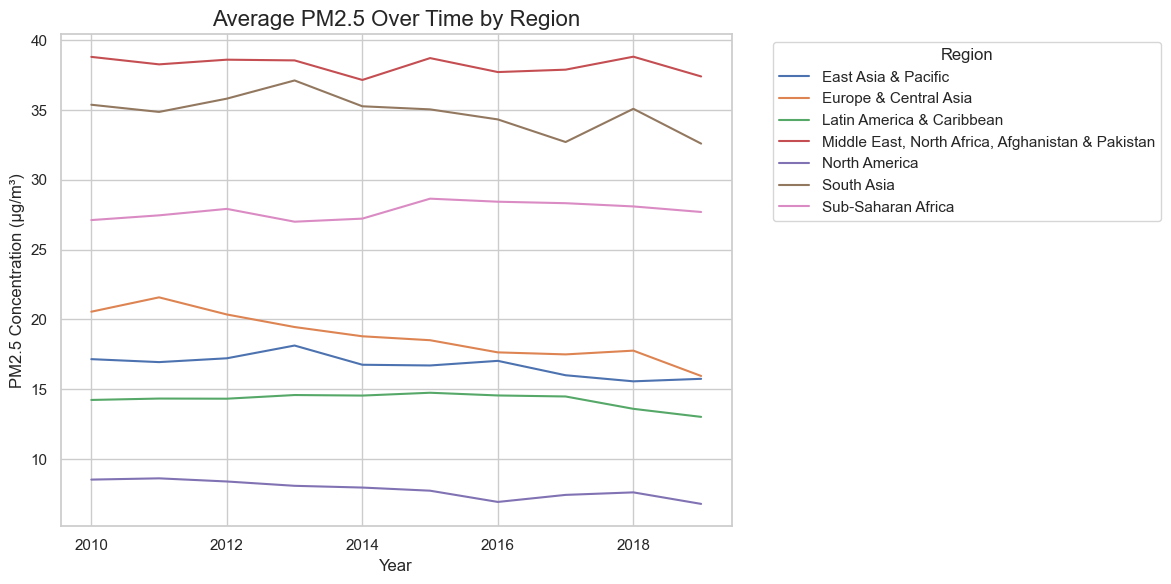

In [14]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=d.groupby(["year", "region"], as_index=False)["pm25"].mean(),
    x="year", y="pm25", hue="region"
)
plt.title("Average PM2.5 Over Time by Region", fontsize=16)
plt.ylabel("PM2.5 Concentration (µg/m³)")
plt.xlabel("Year")
plt.legend(title="Region", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


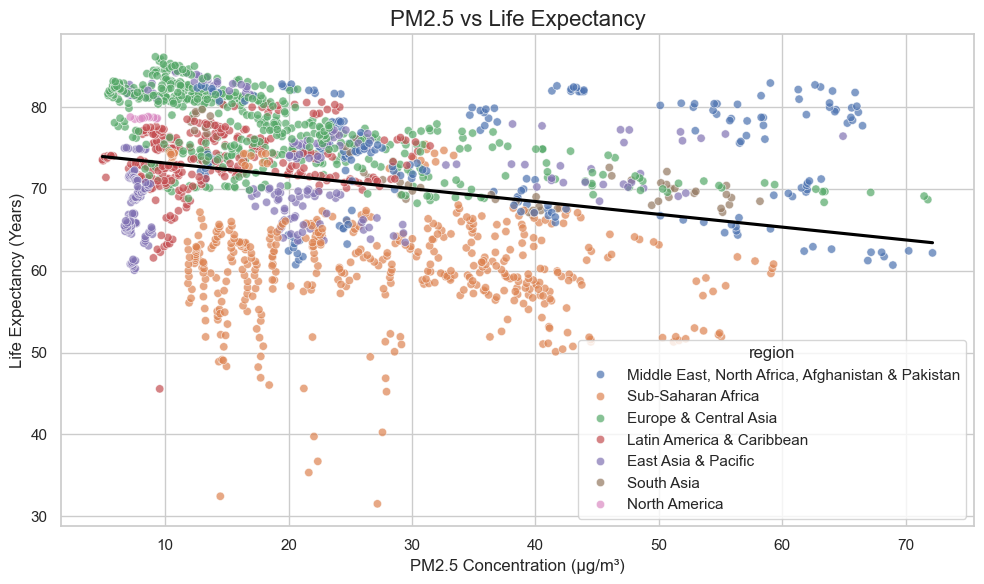

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=d, x="pm25", y="life_expectancy_yrs",
    hue="region", alpha=0.7
)
sns.regplot(
    data=d, x="pm25", y="life_expectancy_yrs",
    scatter=False, color="black", ci=None
)
plt.title("PM2.5 vs Life Expectancy", fontsize=16)
plt.xlabel("PM2.5 Concentration (µg/m³)")
plt.ylabel("Life Expectancy (Years)")
plt.tight_layout()
plt.show()


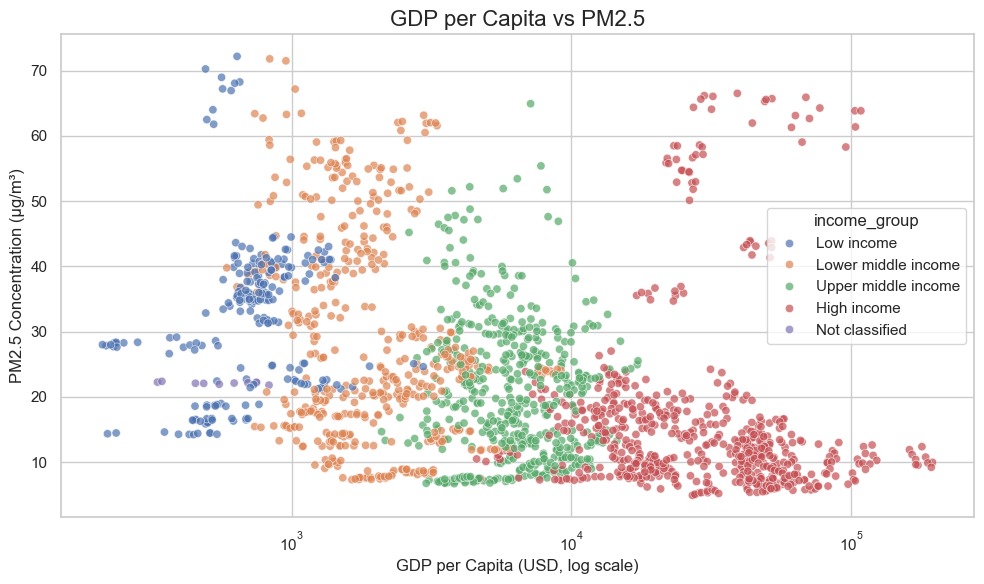

In [16]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=d, x="gdp_per_capita_usd", y="pm25",
    hue="income_group", alpha=0.7
)
plt.xscale("log")
plt.title("GDP per Capita vs PM2.5", fontsize=16)
plt.xlabel("GDP per Capita (USD, log scale)")
plt.ylabel("PM2.5 Concentration (µg/m³)")
plt.tight_layout()
plt.show()


In [17]:
import statsmodels.api as sm

# Drop missing values for modeling
model_df = d.dropna(subset=["life_expectancy_yrs", "pm25", "gdp_per_capita_usd", "urban_pop_pct"])

# Features & target
X = model_df[["pm25", "gdp_per_capita_usd", "urban_pop_pct"]]
X = sm.add_constant(X)  # adds intercept
y = model_df["life_expectancy_yrs"]

# OLS regression
model = sm.OLS(y, X).fit(cov_type="HC3")  # robust standard errors
print(model.summary())


                             OLS Regression Results                            
Dep. Variable:     life_expectancy_yrs   R-squared:                       0.489
Model:                             OLS   Adj. R-squared:                  0.488
Method:                  Least Squares   F-statistic:                     450.9
Date:                 Fri, 08 Aug 2025   Prob (F-statistic):          7.43e-219
Time:                         13:01:04   Log-Likelihood:                -5819.5
No. Observations:                 1818   AIC:                         1.165e+04
Df Residuals:                     1814   BIC:                         1.167e+04
Df Model:                            3                                         
Covariance Type:                   HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 62.5

In [18]:
# Save enriched dataset for the dashboard
enriched_path = "../data/processed/enriched_country_year.csv"
d.to_csv(enriched_path, index=False)
enriched_path


'../data/processed/enriched_country_year.csv'

In [19]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Data for modeling
model_df = d.dropna(subset=["life_expectancy_yrs","pm25","gdp_per_capita_usd","urban_pop_pct"]).copy()
X = sm.add_constant(model_df[["pm25","gdp_per_capita_usd","urban_pop_pct"]])
y = model_df["life_expectancy_yrs"]

# OLS with robust SEs
ols = sm.OLS(y, X).fit(cov_type="HC3")

# Tidy table
table = pd.DataFrame({
    "coef": ols.params,
    "robust_se": ols.bse,
    "t": ols.tvalues,
    "p>|t|": ols.pvalues
})
table["CI95_low"] = table["coef"] - 1.96*table["robust_se"]
table["CI95_high"] = table["coef"] + 1.96*table["robust_se"]

# Nice formatting
tidy = table.round(4)
tidy


,coef,robust_se,t,p>|t|,CI95_low,CI95_high
const,62.5810,0.4975,125.7783,0.0,61.6058,63.5562
pm25,-0.0685,0.0098,-6.9704,0.0,-0.0878,-0.0492
gdp_per_capita_usd,0.0001,0.0000,11.0383,0.0,0.0001,0.0001
urban_pop_pct,0.1444,0.0084,17.2527,0.0,0.1280,0.1608


In [22]:
out_path = "../reports/figures/regression_table.csv"
tidy.to_csv(out_path)
out_path


'../reports/figures/regression_table.csv'

In [23]:
from sklearn.preprocessing import StandardScaler

std_X = pd.DataFrame(StandardScaler().fit_transform(model_df[["pm25","gdp_per_capita_usd","urban_pop_pct"]]),
                     columns=["pm25","gdp_per_capita_usd","urban_pop_pct"])
std_X = sm.add_constant(std_X)
std_y = StandardScaler().fit_transform(model_df[["life_expectancy_yrs"]]).ravel()

std_model = sm.OLS(std_y, std_X).fit(cov_type="HC3")
std_coefs = std_model.params.rename("std_coef").to_frame()
std_coefs


,std_coef
const,-1.139930e-15
pm25,-1.183284e-01
gdp_per_capita_usd,3.513189e-01
urban_pop_pct,3.972063e-01


In [24]:
full_table = tidy.join(std_coefs, how="left")
full_table.to_csv("../reports/figures/regression_table_with_std.csv")
full_table


,coef,robust_se,t,p>|t|,CI95_low,CI95_high,std_coef
const,62.5810,0.4975,125.7783,0.0,61.6058,63.5562,-1.139930e-15
pm25,-0.0685,0.0098,-6.9704,0.0,-0.0878,-0.0492,-1.183284e-01
gdp_per_capita_usd,0.0001,0.0000,11.0383,0.0,0.0001,0.0001,3.513189e-01
urban_pop_pct,0.1444,0.0084,17.2527,0.0,0.1280,0.1608,3.972063e-01


In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_noconst = model_df[["pm25","gdp_per_capita_usd","urban_pop_pct"]].assign(const=1.0)
vif = pd.DataFrame({
    "feature": X_noconst.columns,
    "VIF": [variance_inflation_factor(X_noconst.values, i) for i in range(X_noconst.shape[1])]
}).sort_values("VIF", ascending=False)
vif


,feature,VIF
3,const,11.817078
1,gdp_per_capita_usd,1.515533
2,urban_pop_pct,1.463449
0,pm25,1.068096


In [26]:
plt.savefig("../reports/figures/pm25_by_region_over_time.png", dpi=200, bbox_inches="tight")


<Figure size 1000x600 with 0 Axes>

In [27]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ----- Features -----
dfm = d.dropna(subset=["life_expectancy_yrs","pm25","gdp_per_capita_usd","urban_pop_pct"]).copy()
dfm["log_gdp_pc"] = np.log(dfm["gdp_per_capita_usd"].clip(lower=1))  # avoid log(0)

# Model A: raw GDP
Xa = sm.add_constant(dfm[["pm25","gdp_per_capita_usd","urban_pop_pct"]])
ya = dfm["life_expectancy_yrs"]
ols_a = sm.OLS(ya, Xa).fit(cov_type="HC3")

# Model B: log GDP
Xb = sm.add_constant(dfm[["pm25","log_gdp_pc","urban_pop_pct"]])
yb = dfm["life_expectancy_yrs"]
ols_b = sm.OLS(yb, Xb).fit(cov_type="HC3")

print("=== Model A: raw GDP ===")
print(ols_a.summary())
print("\n=== Model B: log GDP ===")
print(ols_b.summary())

# Compare fit
cmp = pd.DataFrame({
    "model": ["Raw GDP","Log GDP"],
    "R2_adj": [ols_a.rsquared_adj, ols_b.rsquared_adj],
    "AIC": [ols_a.aic, ols_b.aic],
    "BIC": [ols_a.bic, ols_b.bic]
})
display(cmp)

# Standardized coefficients for Model B (easier interpretation)
scaler_X = StandardScaler()
Xs = pd.DataFrame(scaler_X.fit_transform(dfm[["pm25","log_gdp_pc","urban_pop_pct"]]),
                  columns=["pm25","log_gdp_pc","urban_pop_pct"])
Xs = sm.add_constant(Xs)
ys = StandardScaler().fit_transform(dfm[["life_expectancy_yrs"]]).ravel()
ols_b_std = sm.OLS(ys, Xs).fit(cov_type="HC3")

std_coefs = pd.DataFrame({"std_coef": ols_b_std.params})
display(std_coefs)

# VI


=== Model A: raw GDP ===
                             OLS Regression Results                            
Dep. Variable:     life_expectancy_yrs   R-squared:                       0.489
Model:                             OLS   Adj. R-squared:                  0.488
Method:                  Least Squares   F-statistic:                     450.9
Date:                 Fri, 08 Aug 2025   Prob (F-statistic):          7.43e-219
Time:                         13:15:18   Log-Likelihood:                -5819.5
No. Observations:                 1818   AIC:                         1.165e+04
Df Residuals:                     1814   BIC:                         1.167e+04
Df Model:                            3                                         
Covariance Type:                   HC3                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
c

,model,R2_adj,AIC,BIC
0,Raw GDP,0.487972,11646.985162,11669.007131
1,Log GDP,0.681542,10783.637080,10805.659049


,std_coef
const,-1.139930e-15
pm25,5.518139e-02
log_gdp_pc,8.391777e-01
urban_pop_pct,8.967015e-03
